<a href="https://colab.research.google.com/github/Ukendiran-M/Mini-Project-Models/blob/main/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/content/MyDrive/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/content/MyDrive/kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset


Dataset URL: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
License(s): unknown
100% 2.39G/2.40G [00:34<00:00, 178MB/s]
100% 2.40G/2.40G [00:34<00:00, 74.8MB/s]


In [ ]:
!unzip /content/pix2pix-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: edges2shoes/edges2shoes/train/8200_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8201_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8202_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8203_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8204_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8205_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8206_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8207_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8208_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8209_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/820_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8210_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8211_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8212_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8213_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8214_AB.jpg  
  inflating: edges2shoes/edges2shoes/t

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [ ]:
import tensorflow as tf

# List all available physical devices
devices = tf.config.experimental.list_physical_devices('GPU')

# Check if any GPUs are detected
if devices:
    tf.config.experimental.set_memory_growth(devices[0], enable=True)
    print("GPU detected:", devices)
else:
    print("No GPU devices found.")

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0] ,enable=True)
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
BATCH_SIZE = 1
IMAGE_SIZE = 256


In [ ]:

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image


In [ ]:
import os

path = "/content/drive/MyDrive/cityscapes"
x,y = load(os.path.join(path, "train/1.jpg"))
print(x.shape, y.shape)

(256, 256, 3) (256, 256, 3)


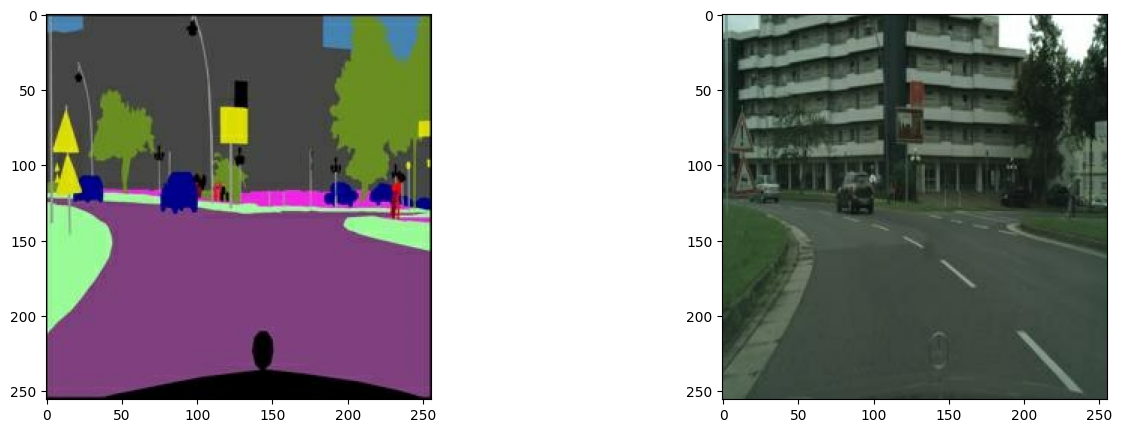

In [ ]:
import matplotlib.pyplot as plt

# Now you can use plt for plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].imshow(x / 255.0)
axes[1].imshow(y / 255.0)
plt.show()

In [ ]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [ ]:

def resize(input_image, real_image):
    input_image = tf.image.resize(input_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image


In [ ]:

def random_jitter(input_image, real_image):
    #if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

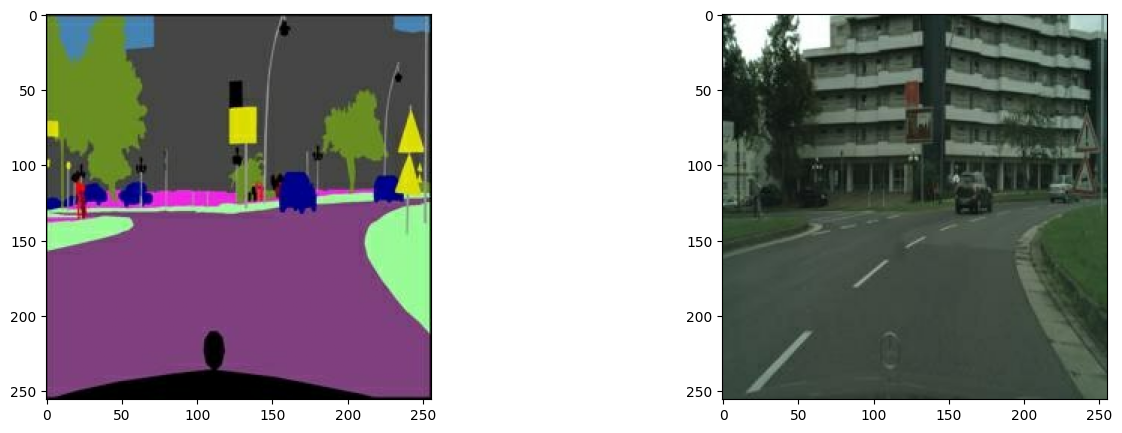

In [ ]:

x_jit, y_jit = random_jitter(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_jit/255.0)
axes[1].imshow(y_jit/255.0)

In [ ]:

def load_train_images(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image,real_image

In [ ]:

def load_test_image(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(path + "/train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:

len(train_dataset)

2985

In [ ]:
test_dataset = tf.data.Dataset.list_files(path + "/val/*.jpg")
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU

# Define the downsample function
def downsample(filters, size, batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding="same", kernel_initializer=init, use_bias=False))
    if batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())
    return result

# Create the model and apply it to the input
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(x, axis=0))
print(down_result.shape)

(1, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, ReLU, LeakyReLU

# Define the upsample function
def upsample(filters, size, dropout=False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding="same", kernel_initializer=init, use_bias=False))
    result.add(BatchNormalization())
    if dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

# Create the model and apply it to the input
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, ReLU, LeakyReLU, Input
from tensorflow.keras.models import Model

# Define the generator function
def generator():
    inputs = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4),
        upsample(64, 4)
    ]

    # Build the model
    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create and summarize the generator model
gen = generator()
gen.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_20 (Sequential)           │ (None, 64, 64, 128)         │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_21 (Sequential)           │ (None, 32, 32, 256)         │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_22 (Sequential)           │ (None, 16, 16, 512)         │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_23 (Sequential)           │ (None, 32, 32, 512)         │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_24 (Sequential)           │ (None, 64, 64, 256)         │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_25 (Sequential)           │ (None, 128, 128, 128)       │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_26 (Sequential)           │ (None, 256, 256, 64)        │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 512, 512, 3)         │           3,075 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,712,899 (37.05 MB)

 Trainable params: 9,709,187 (37.04 MB)

 Non-trainable params: 3,712 (14.50 KB)

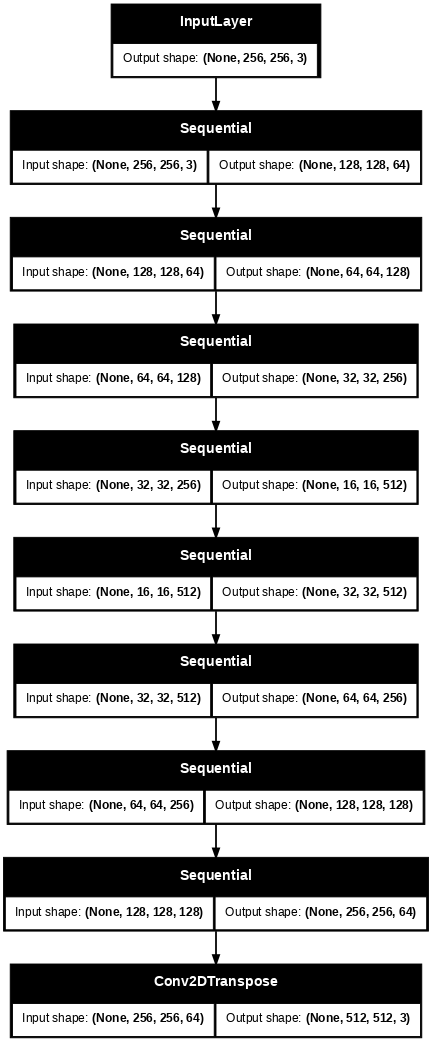

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, ReLU, LeakyReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model  # Import plot_model

# Define the generator function
def generator():
    inputs = Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4),
        upsample(64, 4)
    ]

    # Build the model
    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create the generator model
gen = generator()

# Plot the model architecture
plot_model(gen, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the optimizers
generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)


In [ ]:

def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (15,15))
    display_list= [test_input[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicton Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()


In [ ]:
if not os.path.exists("output"):
    os.mkdir("output")

In [ ]:

epochs = 50

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)

        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [ ]:

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

In [ ]:
import keras
keras.backend.clear_session()

In [ ]:
import time
import tensorflow as tf

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in train_ds:
            # Perform a training step here
            train_step(input_, target)

        print(f'Epoch {epoch+1}/{epochs} took {time.time() - start:.2f} seconds')

        # Optionally save images or checkpoints after each epoch
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)

In [ ]:
def fit(train_ds, epochs, test_ds, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    for epoch in range(epochs):
        start = time.time()
        for input_image, target_image in train_ds:
            gen_loss, disc_loss = train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)

        print(f'Epoch {epoch+1}/{epochs} took {time.time() - start:.2f} seconds')
        print(f'Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

        # Save images or checkpoints after each epoch
        for input_image, target_image in test_ds.take(1):
            save_images(generator, input_image, target_image, epoch)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import os
import time

# Define generator and discriminator
def generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 7, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    outputs = x
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu')(inputs)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)

    outputs = x
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Define the optimizers
gen_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

# Define the loss function
loss_fn = BinaryCrossentropy(from_logits=True)

# Define the train_step function
@tf.function
def train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(input_image, training=True)
        real_output = discriminator(target_image, training=True)
        fake_output = discriminator(generated_image, training=True)

        disc_loss = loss_fn(real_output, fake_output)
        gen_loss = loss_fn(fake_output, tf.ones_like(fake_output))

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Define the save_images function
def save_images(generator, input_image, target_image, epoch, output_dir='images'):
    generated_image = generator(input_image, training=False)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    generated_image = (generated_image.numpy() * 0.5 + 0.5) * 255.0
    target_image = (target_image.numpy() * 0.5 + 0.5) * 255.0

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(input_image[0])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated')
    plt.imshow(generated_image[0].astype(int))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Target')
    plt.imshow(target_image[0].astype(int))
    plt.axis('off')

    plt.savefig(f'{output_dir}/epoch_{epoch+1}.png')
    plt.close()

# Define the fit function
def fit(train_ds, epochs, test_ds, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    for epoch in range(epochs):
        start = time.time()
        for input_image, target_image in train_ds:
            gen_loss, disc_loss = train_step(input_image, target_image, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)

        print(f'Epoch {epoch+1}/{epochs} took {time.time() - start:.2f} seconds')
        print(f'Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

        # Save images after each epoch
        for input_image, target_image in test_ds.take(1):
            save_images(generator, input_image, target_image, epoch)

# Prepare datasets (example; replace with your actual data)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

# Define the number of epochs
epochs = 10

# Create the models
generator = generator()
discriminator = discriminator()

# Run the training
fit(train_dataset, epochs, test_dataset, generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)

Epoch 1/10 took 600.21 seconds
Generator Loss: 1138531584.0, Discriminator Loss: -9.261738395594392e+18


Epoch 2/10 took 72.46 seconds
Generator Loss: 5925481472.0, Discriminator Loss: -2.6917919974988815e+20


Epoch 3/10 took 71.91 seconds
Generator Loss: 14567540736.0, Discriminator Loss: -1.842744614930627e+21


Epoch 4/10 took 71.63 seconds
Generator Loss: nan, Discriminator Loss: nan


<ipython-input-58-092ef43b3dd1>:72: RuntimeWarning: invalid value encountered in cast
  plt.imshow(generated_image[0].astype(int))


Epoch 5/10 took 71.48 seconds
Generator Loss: nan, Discriminator Loss: nan


Epoch 6/10 took 71.66 seconds
Generator Loss: nan, Discriminator Loss: nan


Epoch 7/10 took 81.90 seconds
Generator Loss: nan, Discriminator Loss: nan


Epoch 8/10 took 72.17 seconds
Generator Loss: nan, Discriminator Loss: nan


Epoch 9/10 took 71.69 seconds
Generator Loss: nan, Discriminator Loss: nan


Epoch 10/10 took 71.50 seconds
Generator Loss: nan, Discriminator Loss: nan
